### Load libraries

In [1]:
import os, sys
from datetime import date
import pandas as pd 
import numpy as np 
import scanpy as sc 
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/usr

<i><b> Set the home directory </b></i>

In [2]:
# Define the home_path 
os.environ['HOME_Nikola_scdgomics'] = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics"
home_path = os.getenv("HOME_Nikola_scdgomics")
home_path

'/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics'

<i><b> Set the container image </b></i>

In [3]:
# Container used for this analysis can be found here : cokorac/cs-core-image-amd64:dev
day = date.today()
print('The last use of the container:', day)

The last use of the container: 2025-06-21


### Load DEGs

In [4]:
# human Ncx RG vs. mm DG RG
hNcx_vs_mmDG = pd.read_csv("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/results/degs/hs_ncx_rg2_vs_mm_dg_rg_1/DEGs_up_hs_ncx_rg2_vs_mm_dg_rg_1.csv")
hNcx_vs_mmDG.rename(columns={'Unnamed: 0':'gene_name'}, inplace=True)
# human Ncx RG vs. mm Ncx RG
hNcx_vs_mmNcx = pd.read_csv("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/results/degs/hs_ncx_rg2_vs_mm_ncx_rg/DEGs_up_hs_ncx_rg2_vs_mm_ncx_rg.csv")
hNcx_vs_mmNcx.rename(columns={'Unnamed: 0':'gene_name'}, inplace=True)
# mm DG RG vs. mm Ncx RG
mmDG_vs_mmNcx = pd.read_csv("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/results/degs/mm_dg_rg1_vs_mm_ncx_rg/DEGs_up_mm_dg_rg1_vs_mm_ncx_rg.csv")
mmDG_vs_mmNcx.rename(columns={'Unnamed: 0':'gene_name'}, inplace=True)

In [5]:
# Convert to lists 
gene_lists = []
for df in [hNcx_vs_mmDG, hNcx_vs_mmNcx, mmDG_vs_mmNcx]:
    gene_lists.append(df['gene_name'].tolist())

hNcx_vs_mmDG_list, hNcx_vs_mmNcx_list, mmDG_vs_mmNcx_list = gene_lists

In [6]:
# Intersect lists (all three comparisons)
common_DEGs_1 = list(set(hNcx_vs_mmDG_list) & set(hNcx_vs_mmNcx_list) & set(mmDG_vs_mmNcx_list))
print(len(common_DEGs_1))

151


In [7]:
# Intersect lists (up in hsNcx vs mmNcx and mmDG vs mmNcx)
common_DEGs_2 = list((set(hNcx_vs_mmNcx_list) & set(mmDG_vs_mmNcx_list)) - (set(hNcx_vs_mmDG_list) & set(hNcx_vs_mmNcx_list) & set(mmDG_vs_mmNcx_list)))
print(len(common_DEGs_2))

1204


In [8]:
# Intersect lists (up in hsNcx vs mmNcx and hsNcx vs mmDG)
common_DEGs_3 = list((set(hNcx_vs_mmNcx_list) & set(hNcx_vs_mmDG_list)) - (set(mmDG_vs_mmNcx_list) & set(hNcx_vs_mmNcx_list) & set(mmDG_vs_mmNcx_list)))
print(len(common_DEGs_3))

1189


### Load the pseudobulk anndata

In [9]:
# Load the pseudobulk anndata
pdata = sc.read_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_psedobulk.h5ad")

In [10]:
# Keep only RG subclusters
pdata_ss = pdata[pdata.obs['leiden_subclustered_G1_RG_ss_merged'].isin(['human_ncx_RG_2', 'mouse_ncx_RG', 'mouse_dg_RG_1'])].copy()

In [11]:
# Define the pseudobulk replicate numbers 
pdata_ss.obs['pseudoreplicate_number'] = range(1, pdata_ss.n_obs + 1)

### Normalize counts

In [12]:
# Store raw counts in layers
pdata_ss.layers['counts'] = pdata_ss.X.copy()
# Normalize, scale and compute pca
sc.pp.normalize_total(pdata_ss, target_sum=1e4, exclude_highly_expressed=True)
pdata_ss.layers['normalized'] = pdata_ss.X.copy()
sc.pp.log1p(pdata_ss)
pdata_ss.layers['log-normalized'] = pdata_ss.X.copy()
sc.pp.scale(pdata_ss, max_value=10)
pdata_ss.layers['normalized-scaled'] = pdata_ss.X.copy()

In [13]:
# up in all three comparisons
group_means_all = sc.get.obs_df(pdata_ss, keys = common_DEGs_1).groupby(pdata_ss.obs['pseudoreplicate_number']).mean()
group_means_all = group_means_all.T

In [14]:
# up in hsNcx vs mmNcx and mmDG vs mmNcx
group_means_2 = sc.get.obs_df(pdata_ss, keys = common_DEGs_2).groupby(pdata_ss.obs['pseudoreplicate_number']).mean()
group_means_2 = group_means_2.T
group_means_2_top150 = group_means_2[:150]

In [15]:
# up in hsNcx vs mmNcx and hsNcx vs mmDG
group_means_3 = sc.get.obs_df(pdata_ss, keys = common_DEGs_3).groupby(pdata_ss.obs['pseudoreplicate_number']).mean()
group_means_3 = group_means_3.T
group_means_3_top150 = group_means_3[:150]

### Plot

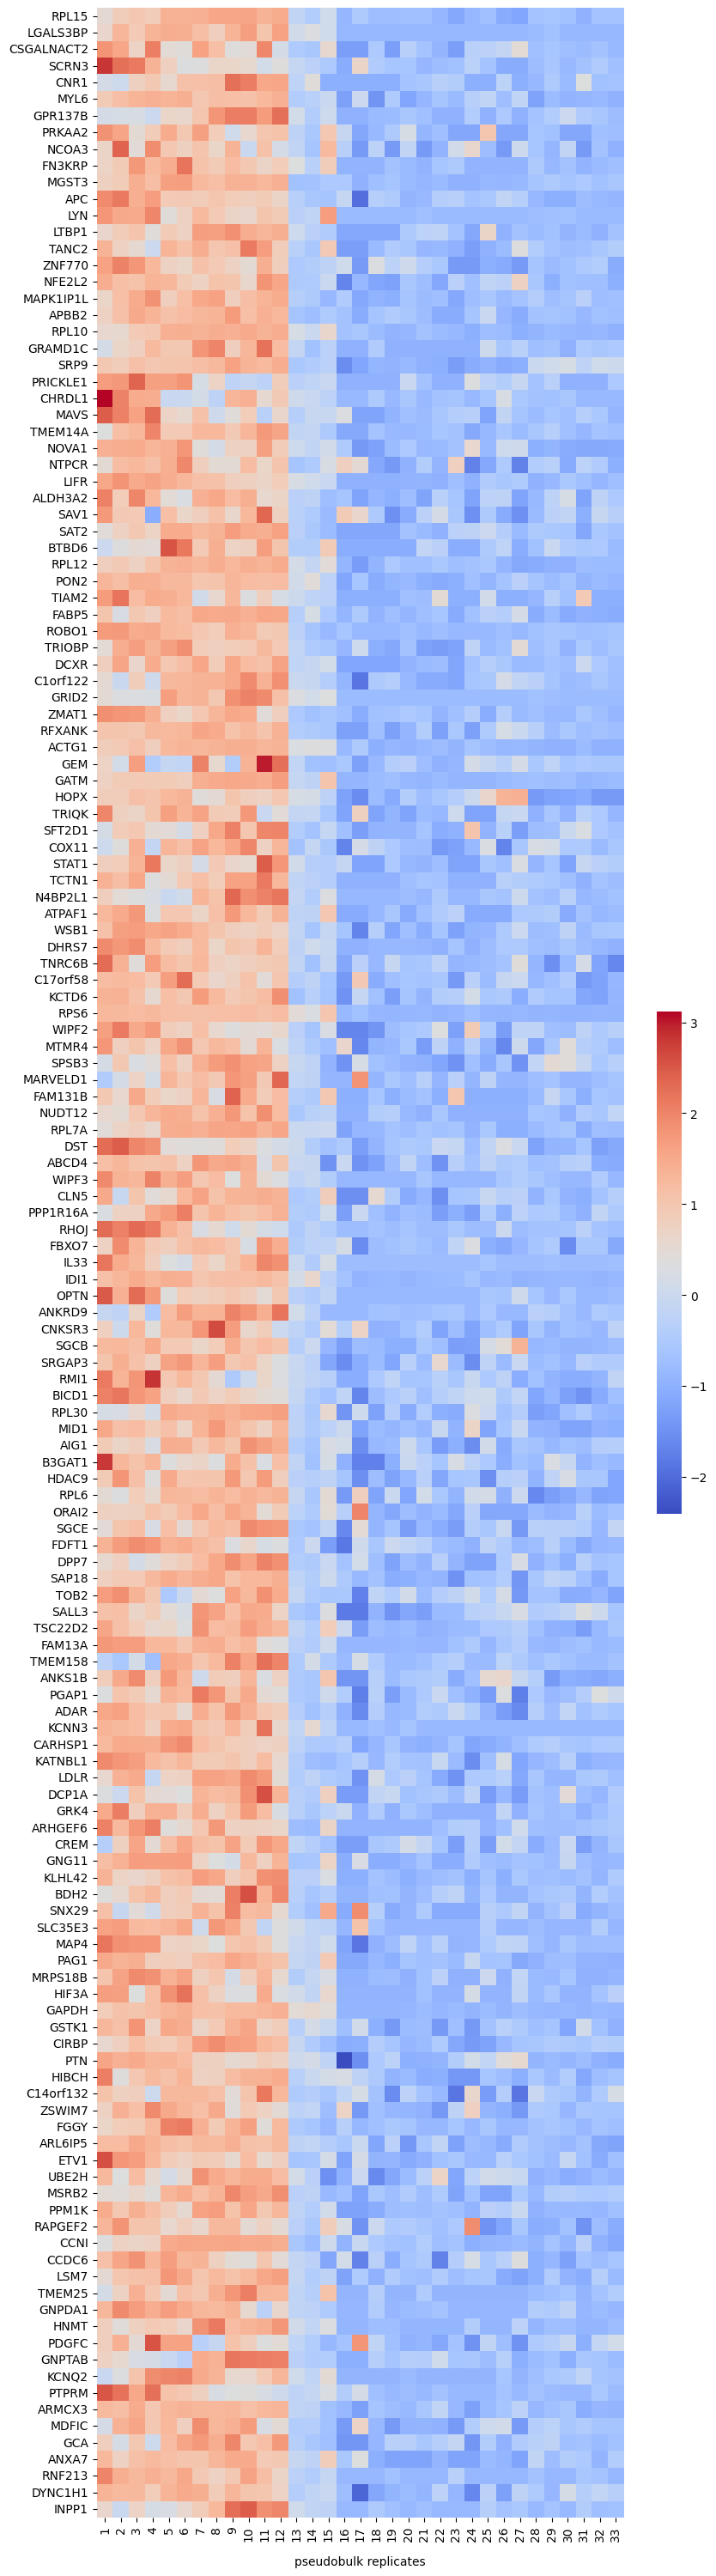

In [16]:
# all three comparisons
plt.figure(figsize = (9, 30))
ax = sns.heatmap(group_means_all, cmap='coolwarm', annot=False, cbar_kws={'shrink':0.2})
plt.tight_layout()
ax.set_xlabel("pseudobulk replicates", labelpad=12)
plt.savefig("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/degs/intersection/Heatmap_intersected_DEGs_all_comparison.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()

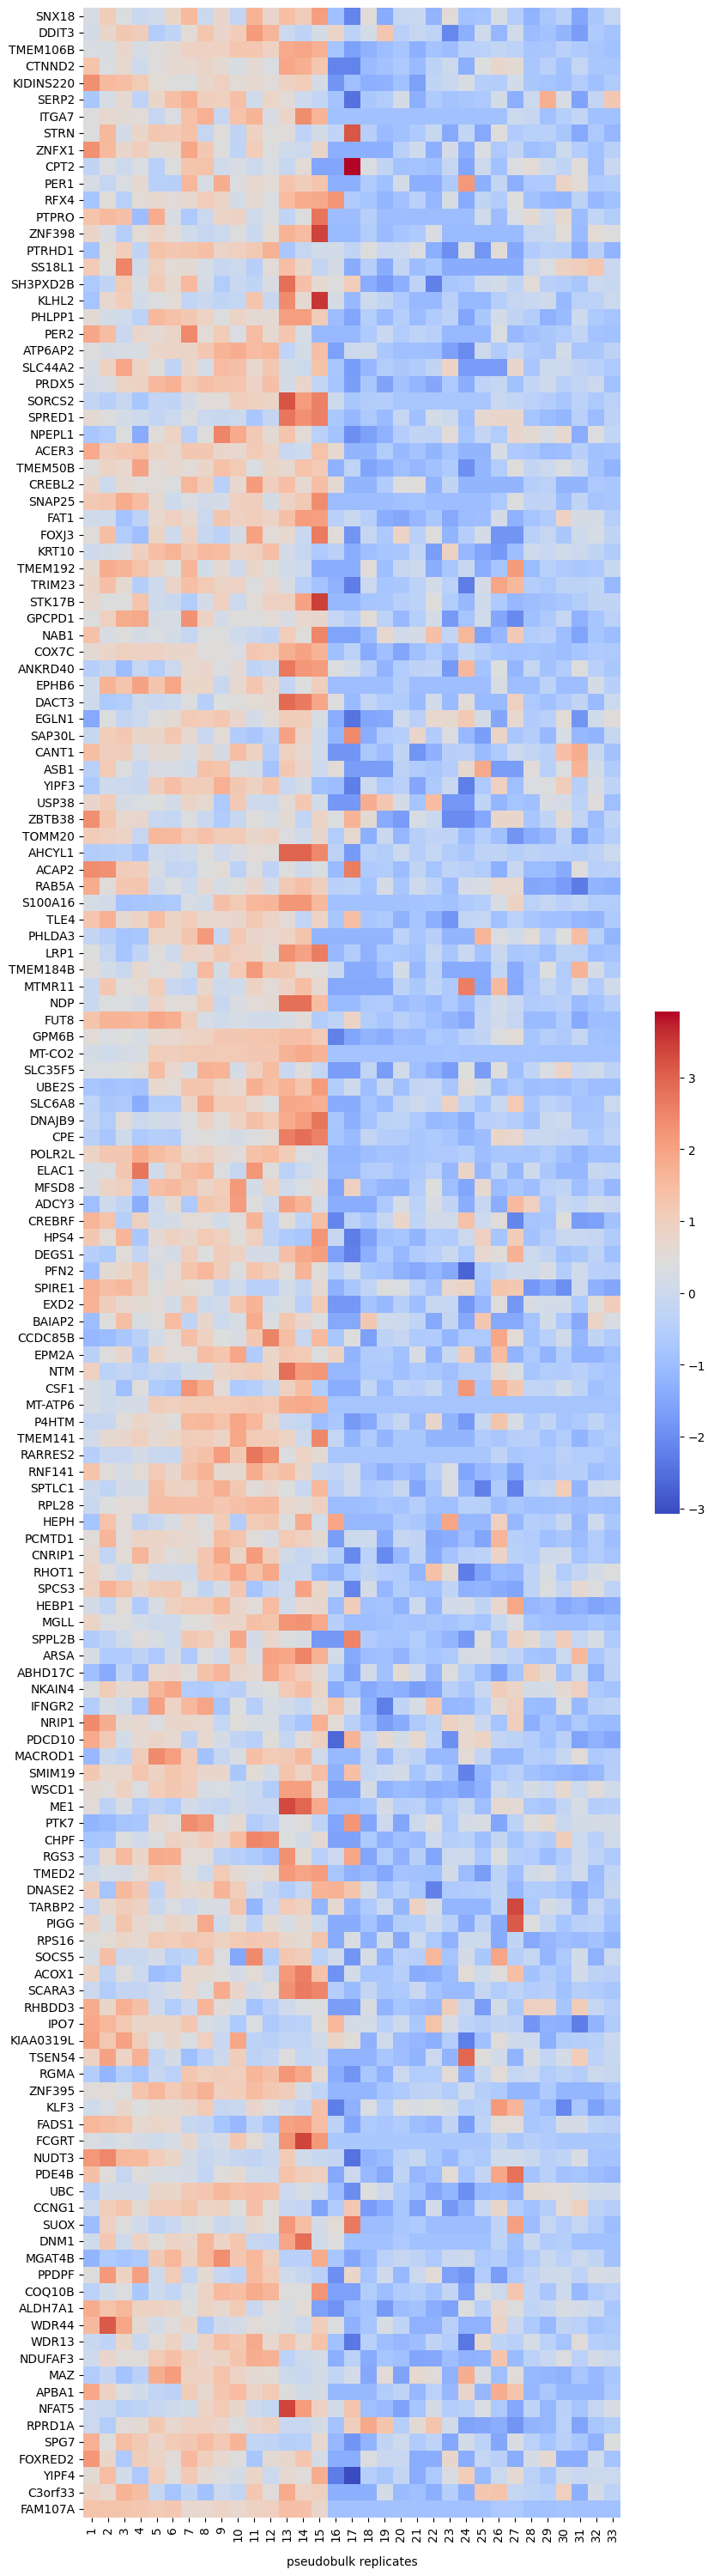

In [17]:
# up in hsNcx vs mmNcx and mmDG vs mmNcx
plt.figure(figsize = (9, 30))
ax = sns.heatmap(group_means_2_top150, cmap='coolwarm', annot=False, cbar_kws={'shrink':0.2})
plt.tight_layout()
ax.set_xlabel("pseudobulk replicates", labelpad=12)
plt.savefig("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/degs/intersection/Heatmap_intersected_DEGs_up_hsNcx_and_mmDG_150genes.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()

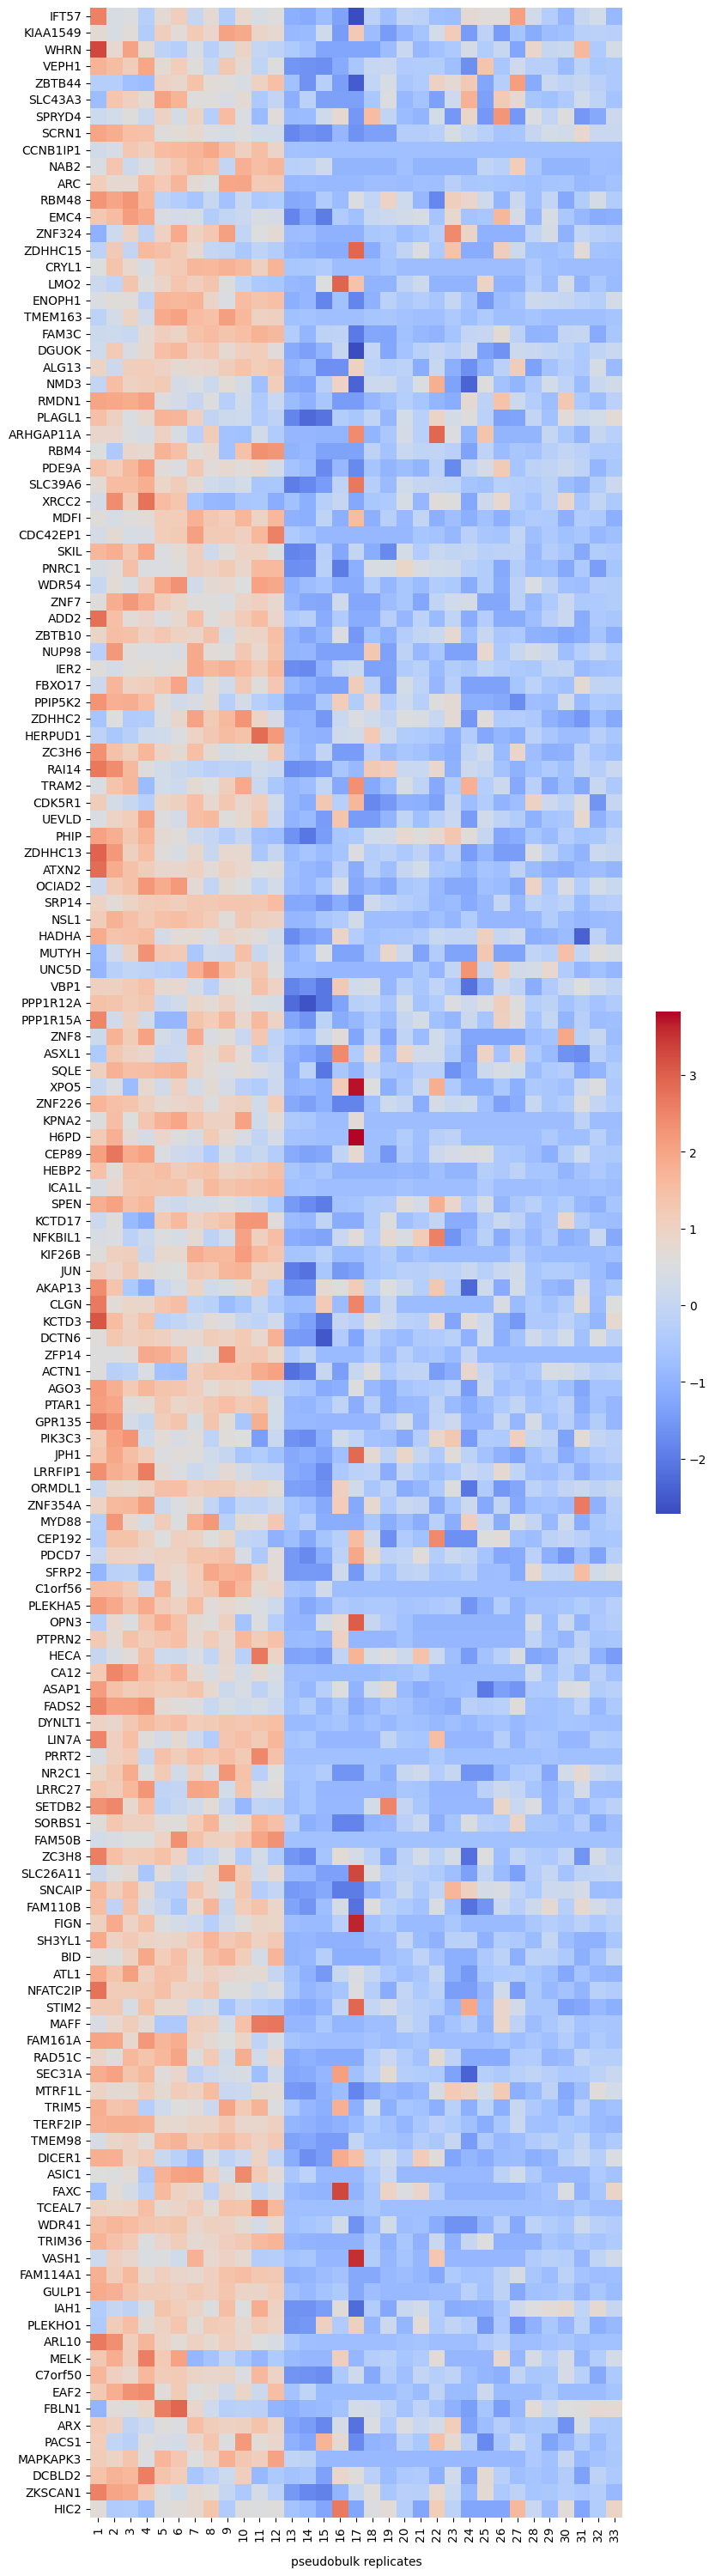

In [18]:
# up in hsNcx vs mmNcx and hsNcx vs mmDG
plt.figure(figsize = (9, 30))
ax = sns.heatmap(group_means_3_top150, cmap='coolwarm', annot=False, cbar_kws={'shrink':0.2})
plt.tight_layout()
ax.set_xlabel("pseudobulk replicates", labelpad=12)
plt.savefig("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/degs/intersection/Heatmap_intersected_DEGs_up_hsNcx_vs_mmNcx_and_mmDG_150genes.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()